In [2]:
import os.path as op
import os
import pandas as pd
import glob
import scipy.stats
import pickle
import numpy as np
import math
os.chdir('../')
import datastruct
import seaborn as sns
import matplotlib.pyplot as plt
import moss
from itertools import groupby  
import statsmodels.api as sm
from psychopy import data, gui, core
from psychopy.tools.filetools import fromFile
import pylab
import math
import statsmodels.formula.api as smf
%matplotlib inline

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
data_dir = '/Users/ianballard/Box/rule_habit/'
subs = glob.glob(data_dir +'su*')
subs = [x.split('/')[-1] for x in subs]
subs = ['subj01','subj02','subj03','subj04','subj05','subj06']

# Load all data files

In [12]:
block_map = {'color': 'train', 'shape':'train', 'motion':'train', 'test':'test'}
sub_df = []
order = {}
for sub in subs:
    files = glob.glob(op.join(data_dir, sub, '*'))
    files = [x for x in files if "test" in x]
    
    for n,f in enumerate(files):
        block_type = f.split('/')[-1].split('_')[-2]
        block_num = int(f.split('/')[-1].split('_')[-1].split('.')[0])
                
        with open(f, 'rb') as f:
            p = pickle.load(f)
            ntrials = len(p.rt)
            
            if p.miniblock:
                miniblock = p.miniblock
            else:
                miniblock = [None]*ntrials
            
            df = pd.DataFrame({'rule': p.active_rule,
                   'rt':p.rt,
                   'resp':p.resp,
                   'correct_resp':p.correct_resp,
                   'correct':p.correct,
                    'sub':sub,
                    'cond':block_type,
                    'trial': np.arange(ntrials),
                    'block': block_map[block_type],
                    'miniblock': miniblock,
                    'block_num': block_num,
                  'color_coherence': p.coherences['color'][:ntrials],
                  'motion_coherence': p.coherences['motion'][:ntrials],
                  'shape_coherence': p.coherences['shape'][:ntrials]})
            sub_df.append(df.copy())
            
    #get block order for that subject
    blocks = [x for x in p.blocks if x != 'test']
    order[sub] = list(dict.fromkeys(blocks))
    print(sub,p.coherence_floor)
    
df = pd.concat(sub_df)
df = df.sort_values(by = ['sub','block_num','trial'])
df = df.set_index('sub')
df['logrt'] = [np.log(x) for x in df['rt']]

subj01 {'color': 0.63, 'motion': 0.03, 'shape': 0.63}
subj02 {'color': 0.53, 'motion': 0.2, 'shape': 0.54}
subj03 {'color': 0.55, 'motion': 0.06, 'shape': 0.56}
subj04 {'color': 0.55, 'motion': 0.05, 'shape': 0.55}
subj05 {'color': 0.55, 'motion': 0.08, 'shape': 0.55}
subj06 {'color': 0.55, 'motion': 0.05, 'shape': 0.55}


In [5]:
order

{'subj01': ['motion', 'color', 'shape'],
 'subj02': ['shape', 'motion', 'color'],
 'subj03': ['motion', 'shape', 'color'],
 'subj04': ['color', 'shape', 'motion'],
 'subj05': ['color', 'shape', 'motion'],
 'subj06': ['shape', 'motion', 'color']}

# Process Session 2 Data

In [16]:
#bin the coherences
for sub in subs:
    for rule in ['color','motion','shape']:

        a = list(set(df.loc[sub][rule + '_coherence']))
        a.sort()
        coherence_map = {x:n for n,x in enumerate(a)}
        df.loc[sub,rule + '_coherence_bin'] = [coherence_map[x] for x in df.loc[sub][rule + '_coherence']]

In [17]:
# df[df['block_num'] == 1]

In [18]:
#get coherence level for each trial
for sub in subs:
    print(sub)
    coherence = []
    coherence_bin = []
    test_type = []
    for n,row in df.loc[sub].iterrows():

        #get coherence for chosen rule
        if row['rule'] == 'motion':
            coherence.append(row['motion_coherence'])
            coherence_bin.append(row['motion_coherence_bin'])

        if row['rule'] == 'color':
            coherence.append(row['color_coherence'])
            coherence_bin.append(row['color_coherence_bin'])

        if row['rule'] == 'shape':
            coherence.append(row['shape_coherence'])
            coherence_bin.append(row['shape_coherence_bin'])
        
        if sub in ['subj01','subj02']:
            #get test condition
            if row['block'] == 'train':
                test_type.append('train')
            elif row['block_num'] < 4:
                test_type.append('train')
            elif row['block_num'] in [6,7]:
                test_type.append(order[sub][0])
            elif row['block_num'] in [10,11]:
                test_type.append(order[sub][1])
            elif row['block_num'] in [14,15]:
                test_type.append(order[sub][2])
        else:
            #get test condition
            if row['block'] == 'train':
                test_type.append('train')
            elif row['block_num'] < 2: #first two blocks
                test_type.append('train')
            elif row['block_num'] in [4,5]:
                test_type.append(order[sub][0])
            elif row['block_num'] in [8,9]:
                test_type.append(order[sub][1])
            elif row['block_num'] in [12,13]:
                test_type.append(order[sub][2])
    df.loc[sub,'coherence'] = coherence
    df.loc[sub,'coherence_bin'] = coherence_bin
    df.loc[sub,'test_type'] = test_type

subj01
subj02
subj03
subj04
subj05
subj06


## Performance on single rule training

subj01 {'color': 0.63, 'motion': 0.03, 'shape': 0.63}
subj02 {'color': 0.53, 'motion': 0.2, 'shape': 0.54}
subj03 {'color': 0.55, 'motion': 0.06, 'shape': 0.56}
subj04 {'color': 0.55, 'motion': 0.05, 'shape': 0.55}
subj05 {'color': 0.55, 'motion': 0.08, 'shape': 0.55}
subj06 {'color': 0.55, 'motion': 0.05, 'shape': 0.55}

(0.4, 1)

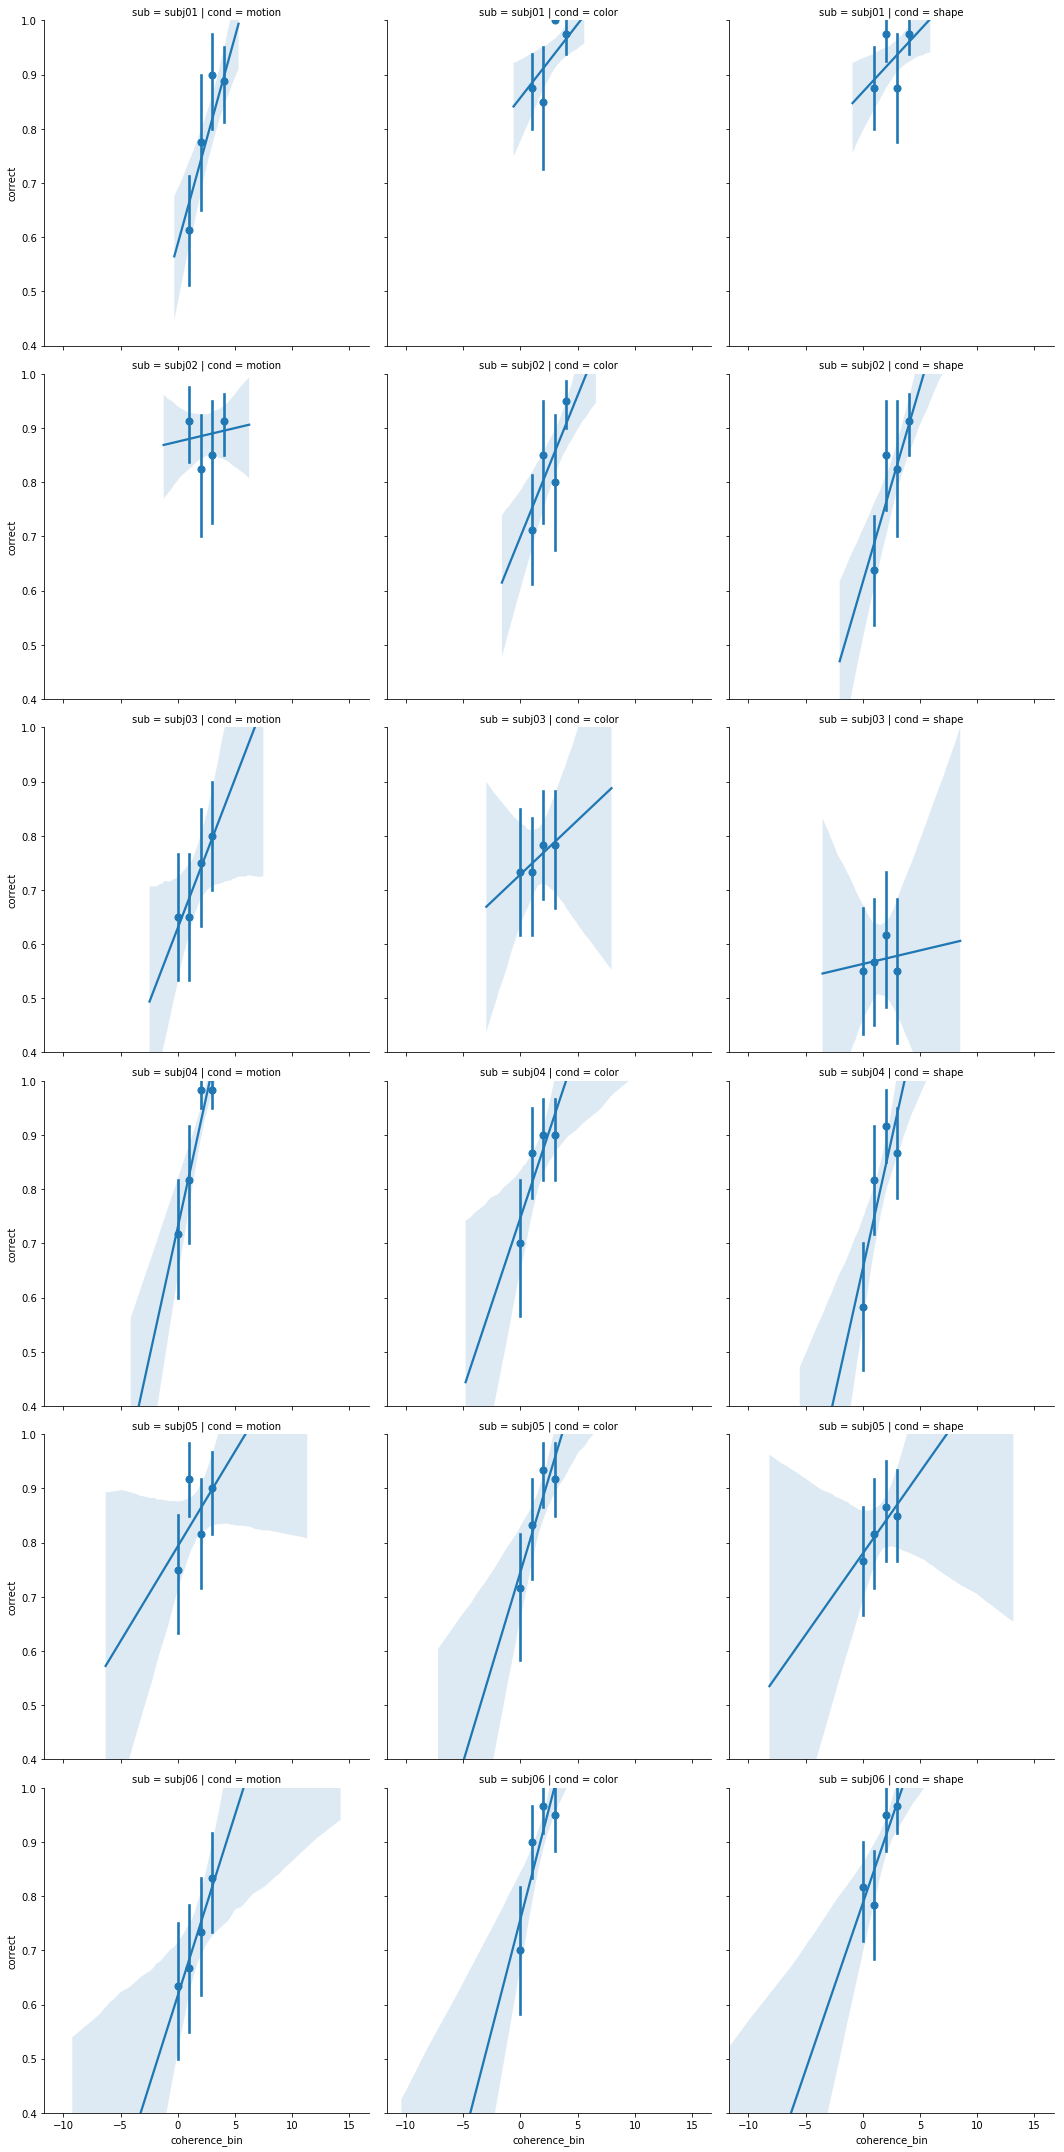

In [19]:
train = df[df['block'] == 'train'].reset_index()
sns.lmplot(x="coherence_bin",
           y="correct",
           col="cond",
           row = 'sub',
           x_bins = 4,
           data=train)
plt.ylim(.4,1)

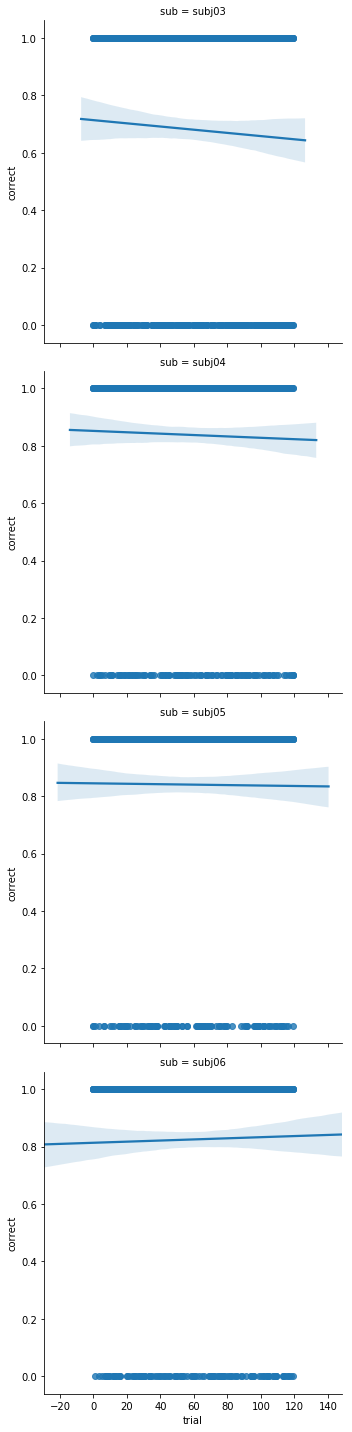

In [8]:
sns.lmplot(x="trial",
           y="correct",
#            col="cond",
           row = 'sub',
#            hue = 'coherence_bin',
#            x_bins = 6,
           data=train)

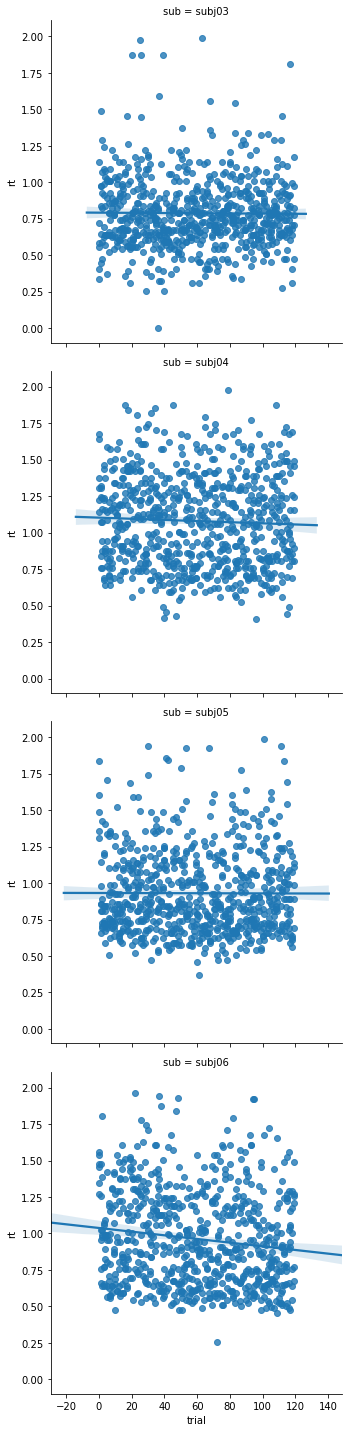

In [9]:
sns.lmplot(x="trial",
           y="rt",
#            col="cond",
           row = 'sub',
#            x_bins = 6,
           data=train)

## Performance on test miniblocks

In [91]:
#get miniblock type
test = df[df['test_type'] != 'train']
for sub in subs:
    miniblock_type = []
    for n,row in test.loc[sub].iterrows():
        tt = row['test_type']
        miniblock = row['miniblock']
        rule = row['rule']
        if tt in miniblock:
            if rule == tt:
                miniblock_type.append('trained')
            else:
                miniblock_type.append('compete')
        else:
            miniblock_type.append('noncompete')
    test.loc[sub,'miniblock_type'] = miniblock_type
        

In [92]:
#switch/stay
for sub in subs:

    switch = ['switch']
    rules = test.loc[sub,'rule'].values
    for n,r in enumerate(rules):
        if n > 0:
            if r ==rules[n-1]:
                switch.append('stay')
            else:
                switch.append('switch')
    test.loc[sub,'switch'] = switch

In [93]:
#switch type and error handling
for sub in subs:
    sub_df = test.loc[sub].copy().reset_index()

    switch_type = ['switch_other']    
    error_last_trial = ['correct']

    for n,row in sub_df.iterrows():
        
        #switch/stay
        rule = row['rule']
        switch = row['switch']
        tt = row['test_type']

        if n > 0:        
            if switch == 'switch':
                if rule == tt:
                    switch_type.append('switch_to')
                elif sub_df.loc[n - 1,'rule'] == tt:
                    switch_type.append('switch_away')
                else:
                    switch_type.append('switch_other')
            else:
                switch_type.append('stay')
        
            #error last trial
            if sub_df.loc[n - 1,'correct']:
                error_last_trial.append('correct')
            else:
                error_last_trial.append('incorrect')
    
    test.loc[sub,'prev_trial_acc'] = error_last_trial       
    test.loc[sub,'switch_type'] = switch_type

In [94]:
#index miniblock trial
miniblock_trial = []
mb = test['miniblock'].values
counter = 0
for n,val in enumerate(mb):
    if n>0:
        if val == mb[n-1]:
            counter +=1
        else:
            counter = 0
    if counter > 11:
        counter = 0
    miniblock_trial.append(counter)
test['miniblock_trial'] = miniblock_trial

In [95]:
# test.loc['subj06'].set_index('block_num').loc[5][['rule','miniblock','test_type','miniblock_type','switch','prev_trial_acc','correct']]

## Performance across coherencies by trial type

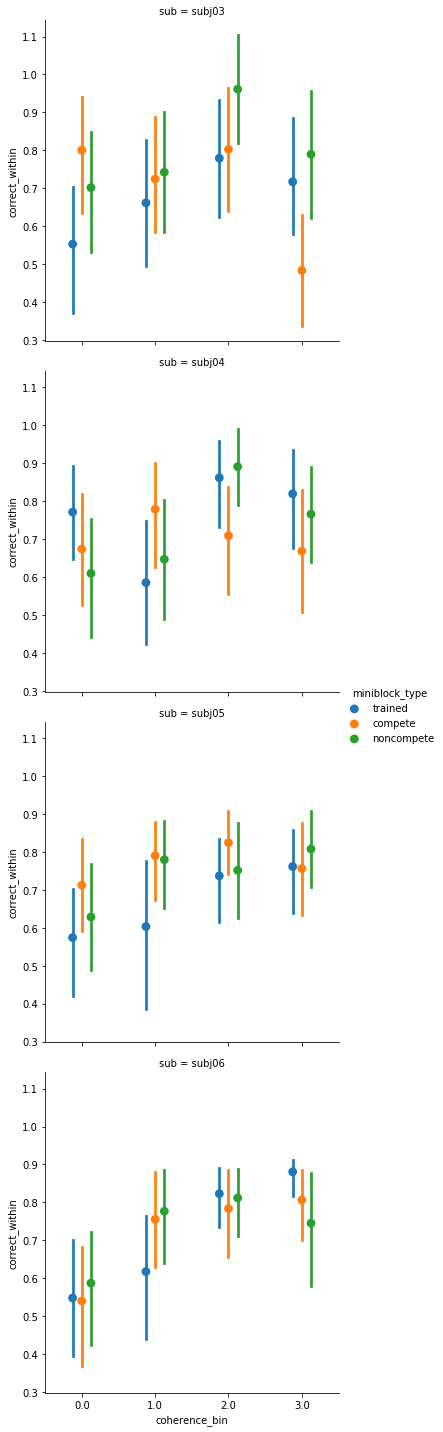

In [66]:
sns.catplot(x="coherence_bin",
           y="correct_within",
           hue = "miniblock_type",
              join = False,
              dodge = .25,
            kind = 'point',
            row = 'sub',
           data=test.reset_index())
plt.savefig(op.abspath('./figs/rule_hab.png'), dpi = 200)

## Post-error slowing

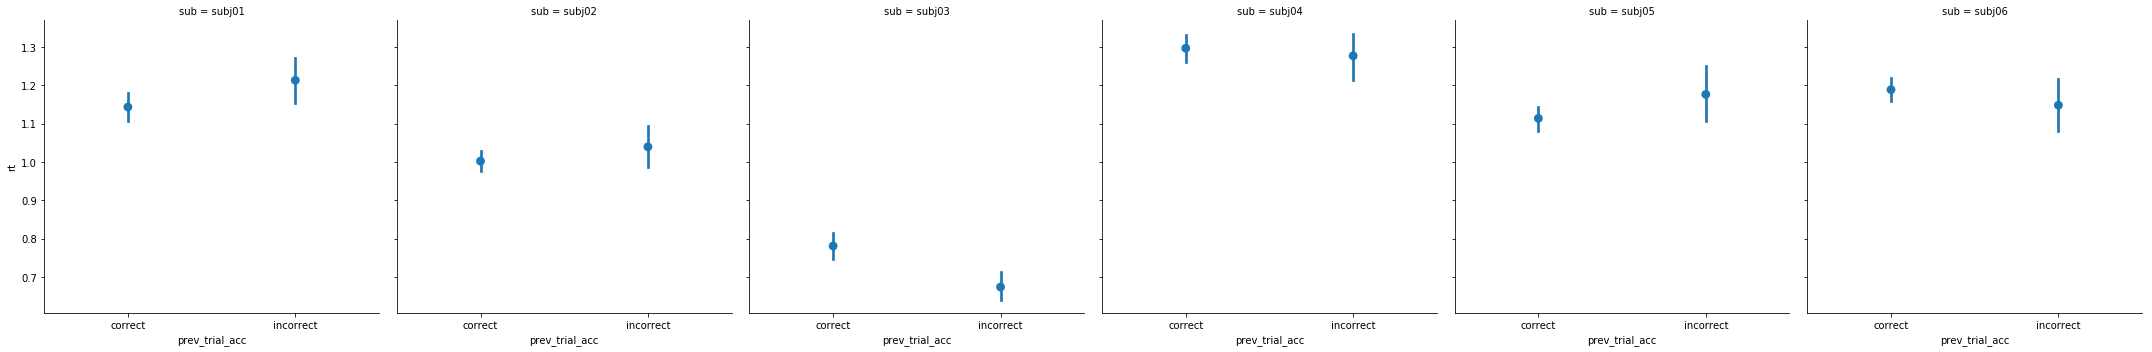

In [96]:
sns.catplot(x = 'prev_trial_acc',
             y = 'rt',
              col = 'sub',
              join = False,
              dodge = .25,
            kind = 'point',
           data=test.reset_index())

## RT by rule

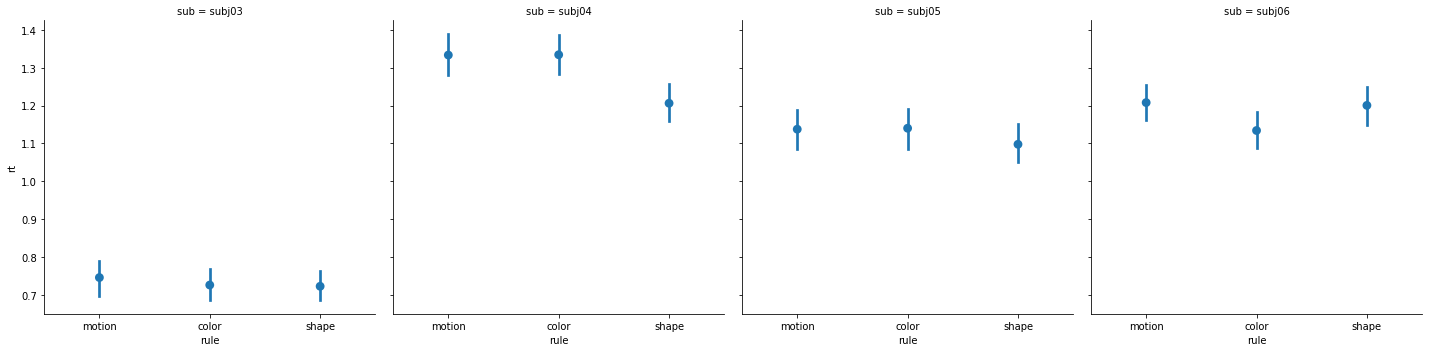

In [17]:
sns.catplot(x = 'rule',
             y = 'rt',
              join = False,
              dodge = .25,
            kind = 'point',
            col = 'sub',
           data=test.reset_index())

## Switch Costs

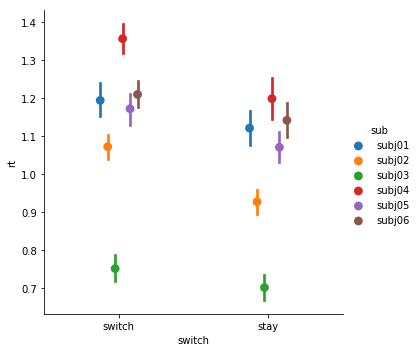

In [97]:
sns.catplot(x = 'switch',
             y = 'rt',
              join = False,
              dodge = .25,
             kind = 'point',
            hue = 'sub',
           data=test.reset_index())

In [99]:
# test['logrt'] = [np.log(x) for x in test['rt']]
# test = test.dropna()

# mod = smf.ols(formula='logrt ~ sub*rule*coherence_bin + sub*prev_trial_acc',
#               data=test.reset_index()).fit()
# test['logrt_resid'] = mod.resid
# mod.summary()

## Behavior collapsed across coherences

In [100]:
#label test sessions by first or second
test_idx = []
for t in test['block_num']:
    if t % 2 == 0:
        test_idx.append('first')
    else:
        test_idx.append('second')
test['test_idx'] = test_idx

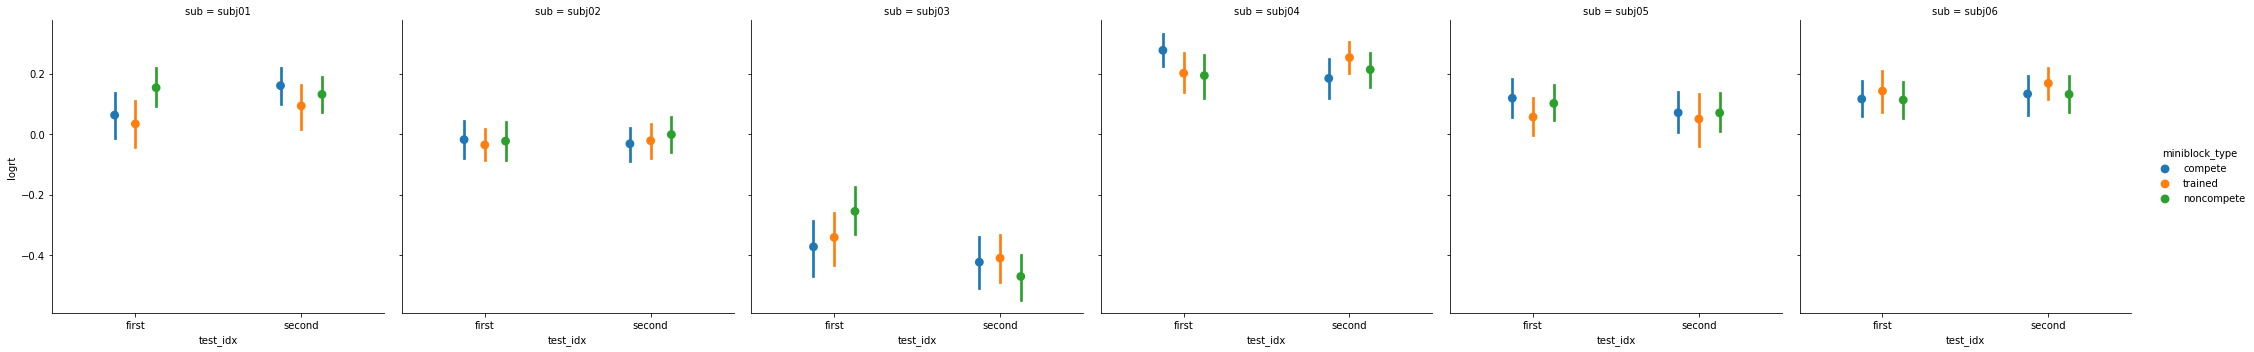

In [101]:
sns.catplot(x="test_idx",
           y="logrt",
              hue = 'miniblock_type',
            col = 'sub',
              join = False,
              dodge = .25,
            kind = 'point',
           data=test.reset_index())

In [102]:
for sub in subs:
    tt = test.loc[sub,'test_type'].values
    test_map = {x:n for n,x in enumerate(order[sub])}
    test.loc[sub,'test_run'] = [test_map[x] for x in tt]

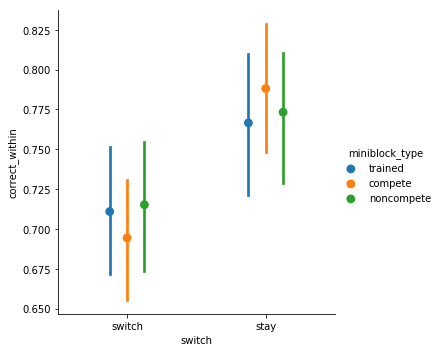

In [121]:
import moss
test = moss.remove_unit_variance(test, 'correct','sub')
sns.catplot(x = 'switch',
              hue = 'miniblock_type',
             y = 'correct_within',
              join = False,
              dodge = .25,
            hue_order = ['trained','compete','noncompete'],
#             row = 'test_idx',
#             col = 'test_run',
              kind = 'point',
           data=test.reset_index())
plt.savefig(op.abspath('./figs/' + sub + '_choice.png'), dpi = 200)

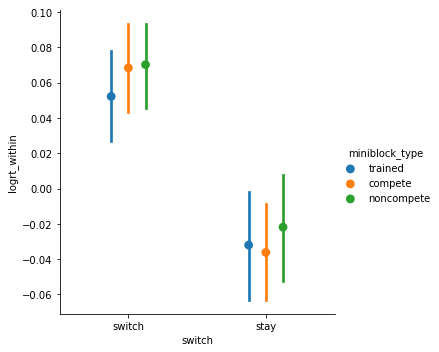

In [119]:
test = moss.remove_unit_variance(test, 'logrt','sub')
sns.catplot(x = 'switch',
              hue = 'miniblock_type',
             y = 'logrt_within',
              join = False,
              dodge = .25,
#             row = 'test_idx',
#             col = 'test_run',
            hue_order = ['trained','compete','noncompete'],
              kind = 'point',
           data=test.reset_index())
plt.savefig(op.abspath('./figs/' + sub + '_rt.png'), dpi = 200)

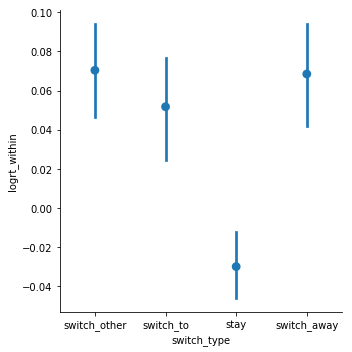

In [118]:
sns.catplot(x = 'switch_type',
             y = 'logrt_within',
              join = False,
#             hue = 'sub',
              dodge = .25,
            kind = 'point',
           data=test.reset_index())

# Analyze training data

In [4]:
sub_df = []
for sub in subs:
    files = glob.glob(op.join(data_dir, sub, '*'))
    files = [x for x in files if "training" in x]
    files = [x for x in files if "retrain" not in x]
    
    for n,f in enumerate(files):
        
        block_type = f.split('/')[-1].split('_')[-2].split('.')[0]
        block_num = int(f.split('/')[-1].split('_')[-1].split('.')[0])

        if block_type[0] == 's':
#             block_num = int(block_type[5:])
            block_type = 'shape'
        
        if block_type[0] == 'c':
#             block_num = int(block_type[5:])
            block_type = 'color'
        
        if block_type[0] == 'm':
#             block_num = int(block_type[6:])
            block_type = 'motion'
                
        with open(f, 'rb') as f:
            p = pickle.load(f)
            ntrials = len(p.rt)
            
            df = pd.DataFrame({'rule': p.training_step,
                   'rt':p.rt,
                   'resp':p.resp,
                   'correct_resp':p.correct_resp,
                    'sub':sub,
                    'cond':block_type,
                    'trial': np.arange(ntrials),
                    'block': block_map[block_type],
                    'block_num': block_num,
                  'coherence': p.coherence_record[p.training_step][:ntrials]})
            sub_df.append(df.copy())
    
df = pd.concat(sub_df)
df = df.sort_values(by = ['sub','block_num','trial'])
df['correct'] = df['correct_resp'] == df['resp']
df['block_num'] = [math.floor(x/3) for x in df['block_num']]
df['grand_trial'] = [x*40 + y for x,y in zip(df['block_num'],df['trial'])]
# df = df.set_index(['sub','cond','block_num'])

ValueError: invalid literal for int() with base 10: 'train'

In [27]:
sub_df = []
for sub in subs:
    files = glob.glob(op.join(data_dir, sub, '*'))
    files = [x for x in files if "psydat" in x]

    for n,f in enumerate(files):
        rule = f.split('/')[-1].split('_')[-1].split('.')[0]

        data = fromFile(f)
        for stair in data.staircases:
            
            
            psychophys = pd.DataFrame({'rule': rule,
                    'sub':sub,
                  'reversal_intensity': np.mean(stair.reversalIntensities[-3:])},
                             index = [0])
            sub_df.append(psychophys.copy())
    
psychophys = pd.concat(sub_df)
psychophys['coherence'] = psychophys['reversal_intensity']

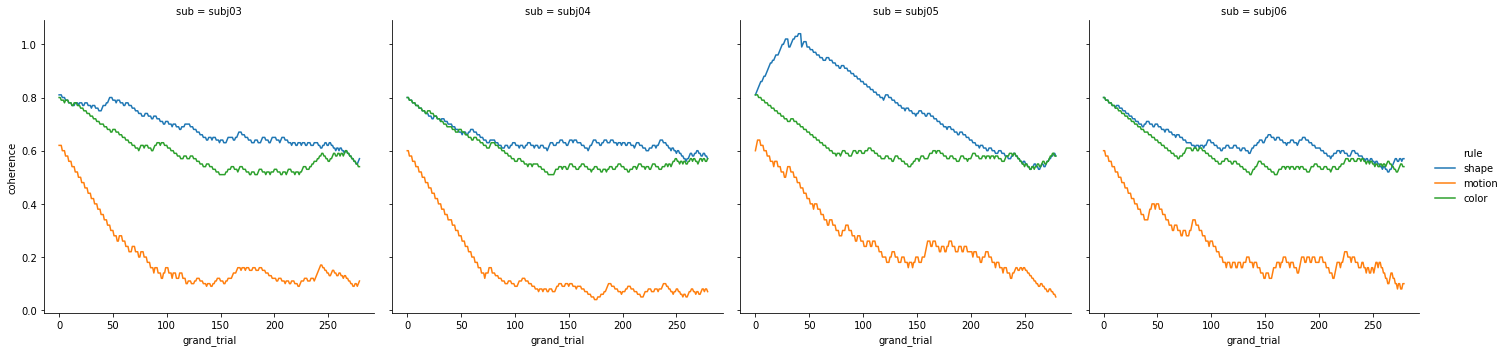

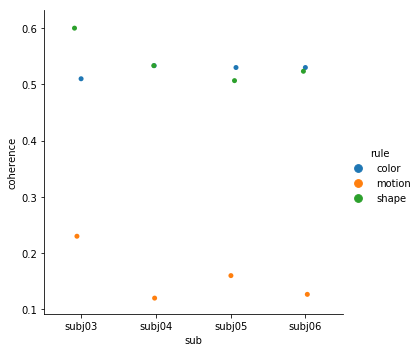

In [28]:
sns.relplot(x = 'grand_trial',
            y = 'coherence',
            hue = 'rule',
            col = 'sub',
            kind = 'line',
            data = df)
sns.catplot(x = 'sub',
           y = 'coherence',
           hue = 'rule',
           data = psychophys)